In [1]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import os

from pclib.nn.models import FCPCN
from pclib.optim.eval import track_vfe, accuracy
from pclib.utils.functional import format_y, identity, shrinkage
from pclib.utils.customdataset import PreloadedDataset
from tqdm import tqdm
from pclib.optim.train import val_pass

In [2]:
seed = 42
# For reproducibility
# os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
torch.backends.cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
torch.manual_seed(seed)

# Scale img transform
class Scale(object):
    def __init__(self, scale_factor):
        self.scale_factor = scale_factor

    def __call__(self, img):
        return img * self.scale_factor + 0.5 * (1 - self.scale_factor)

# Inverse Logistic Sigmoid Transform
class InvLogit(object):
    def __call__(self, x):
        return torch.log(x / (1 - x))

train_transform = transforms.Compose([
    transforms.ToTensor(),
    # Scale(0.9),
    # InvLogit(),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
    # transforms.Normalize((0.1307,), (0.3081,)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    # Scale(0.9),
    # InvLogit(),
    # transforms.Normalize((0.1307,), (0.3081,)),
])

dataset = datasets.MNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())
subset = 40
dataset = torch.utils.data.Subset(dataset, range(subset))

train_dataset = PreloadedDataset.from_dataset(dataset, train_transform, device)
INPUT_SHAPE = 784

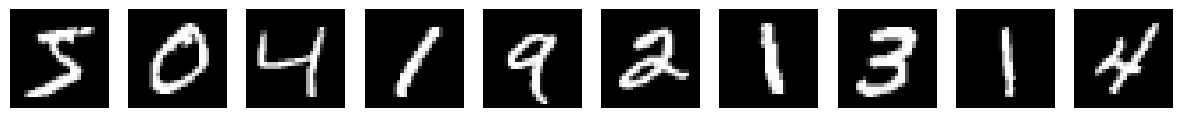

Max value:  tensor(1., device='cuda:0')
Min value:  tensor(0., device='cuda:0')


In [4]:
# Show some images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

# print max min values
print('Max value: ', train_dataset.transformed_images.max())
print('Min value: ', train_dataset.transformed_images.min())

In [5]:
all_stats = {}

In [61]:
def train(
        model,
        train_dataset,
        learn_layer,
        NUM_EPOCHS,
        optimiser,
        scheduler,
        stats,
        norm_grads=False,
        neg_cnst=0.0,
        cd = 0,
):

    pos_state = model.init_state(train_dataset.transformed_images.flatten(1), learn_layer=learn_layer)
    neg_state = model.init_state(train_dataset.transformed_images.flatten(1), learn_layer=learn_layer)

    model.train()
    gamma = torch.ones(pos_state[0]['x'].shape[0], device=device) * 0.2
    cd_gamma = torch.ones(pos_state[0]['x'].shape[0], device=device) * 0.2

    loop = tqdm(range(NUM_EPOCHS), leave=False)
    for i in loop:

        if stats['epoch'] > 0:
            postfix = {'steps': i, 'posVFE': stats['posVfe'][-1]}
            if neg_cnst > 0:
                postfix['negVFE'] = stats['negVfe'][-1]
            if cd > 0:
                postfix['cdVFE'] = stats['cdVfe'][-1]
            loop.set_postfix(postfix)

        # Update particles and calculate new VFE
        model.step(pos_state, gamma, pin_obs=True, learn_layer=learn_layer)
        pos_vfe = model.vfe(pos_state, learn_layer=learn_layer, normalise=norm_grads)
        loss = pos_vfe

        # Same For Negative particles
        if neg_cnst > 0:
            # model.step(neg_state, gamma, pin_obs=False, learn_layer=learn_layer)
            _, neg_state = model(y=pos_state[-1]['x'], pin_target=True)
            neg_vfe = model.vfe(neg_state, learn_layer=learn_layer, normalise=norm_grads)
            loss -= neg_cnst*neg_vfe
            # loss += neg_cnst*neg_vfe
        if cd > 0:
            cd_state = [{k: v.clone() for k, v in state_l.items()} for state_l in pos_state]
            # for _ in range(cd):
            #     model.step(cd_state, cd_gamma, pin_obs=False)
            
            out, _ = model.reconstruct(cd_state[0]['x'], steps=cd, learn_layer=learn_layer)
            cd_state[0]['x'] = out

            cd_vfe = model.vfe(cd_state, learn_layer=learn_layer, normalise=norm_grads)
            loss += -0.75 * cd_vfe

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        if model.has_top:
            model.top.weight.data = model.top.weight.data - torch.diag(model.top.weight.data.diag())

        # for layer in model.layers:
        #     if layer.in_features is not None:
        #         layer.weight.data = F.normalize(layer.weight.data, dim=1)
        # if hasattr(model, 'top'):
        #     model.top.weight.data = F.normalize(model.top.weight.data, dim=1)

        # if norm_grads, recalculate VFE WITHOUT normalisation for plotting (otherwise it will be constant)
        if norm_grads:
            pos_vfe = model.vfe(pos_state, learn_layer=learn_layer, normalise=False)
            if neg_cnst:
                neg_vfe = model.vfe(neg_state, learn_layer=learn_layer, normalise=False)
            if cd > 0:
                cd_vfe = model.vfe(cd_state, learn_layer=learn_layer, normalise=False)

        # Track epoch stats
        stats['posVfe'].append(pos_vfe.item())
        if neg_cnst:
            stats['negVfe'].append(neg_vfe.item())
        if cd:
            stats['cdVfe'].append(cd_vfe.item())

        # Update learning rate
        if scheduler is not None:
            scheduler.step(stats['posVfe'][-1])
        
        stats['epoch'] += 1
    

In [67]:
torch.manual_seed(seed)

model_name = 'original'
model = FCPCN(
    sizes = [INPUT_SHAPE, 512, 256, 128],
    precisions=[-9999, 1.0, 1.0, 1.0],
    bias=True, 
    symmetric=True,
    actv_fn=F.relu,
    steps=20,
    gamma=0.2,
    x_decay=0.0,
    dropout=0.1,
    has_top=True,
).to(device)
stats = {
    'epoch': 0,
    'posVfe': [],
    'negVfe': [],
    'cdVfe': [],
    'valVfe': [],
    'valAcc': [],
}

In [68]:
# weight_decay is pointless when using normalisation
optimiser = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.00)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, patience=500, factor=0.5, verbose=True, threshold=1e-4, min_lr=1e-9)
# NUM_EPOCHS = [25000, 20000, 25000, 1000]
NUM_EPOCHS = [0, 0, 0, 10000]
for i, epochs in enumerate(NUM_EPOCHS):
    learn_layer = i+1 if i+1 < len(model.layers) else None
    train(
        model,
        train_dataset,
        learn_layer,
        epochs,
        optimiser,
        # scheduler,
        None,
        stats,
        norm_grads=False,
        neg_cnst=0.1,
        cd=0,
    )
    if learn_layer is not None:
        print(f'Finished training layer {i+1}')
    else:
        print('Finished Fine-Tuning network')

Finished training layer 1


Finished training layer 2


Finished training layer 3


Finished Fine-Tuning network


In [64]:
all_stats['classic'] = stats

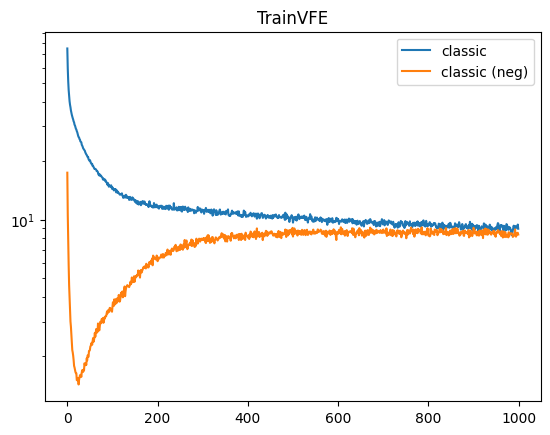

In [65]:
for k, v in all_stats.items():
    plt.plot(v['posVfe'], label=k)
    plt.plot(v['negVfe'], label=k+' (neg)')
plt.legend()
plt.yscale('log')
plt.title('TrainVFE')
plt.show()

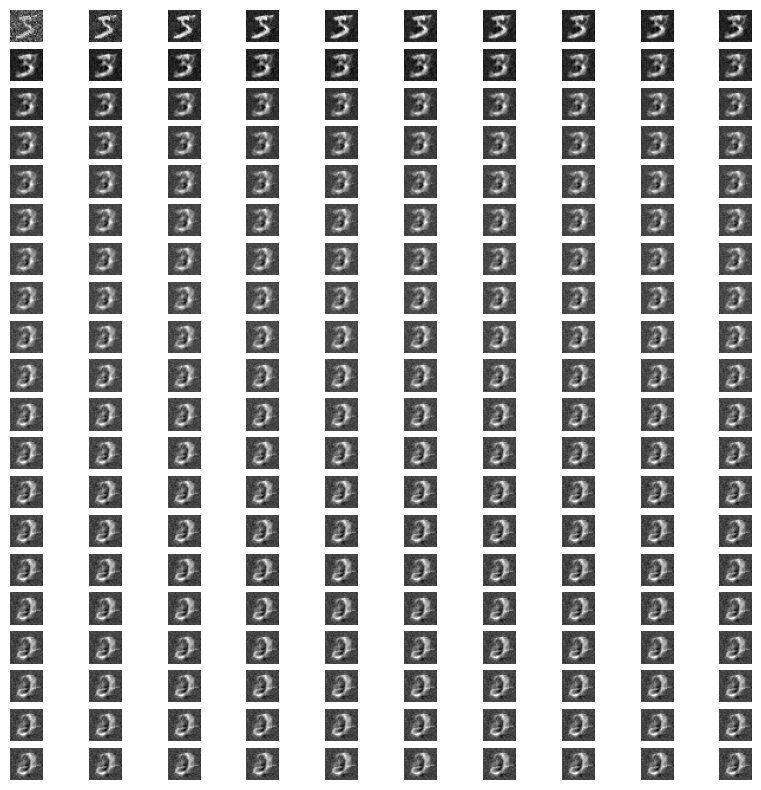

Final MSE:  0.0011810968862846494
Final VFE:  113043.515625
Min MSE:  9.198470797855407e-05
Min VFE:  1.3313496112823486


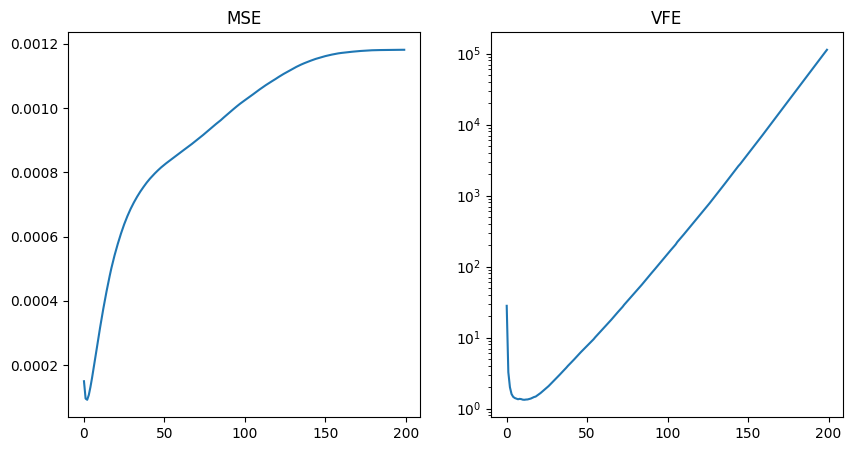

In [66]:
model.eval()
og = train_dataset.images[0].flatten(1).clone()
x = og.clone() + torch.randn_like(og) * 0.3
# x[torch.rand_like(x) > 0.7] = 0.0
# errs = [F.mse_loss(x, og).item()]
vfes = []
errs = []


# Plot the first 1st digit after multiple steps
fig, axes = plt.subplots(20, 10, figsize=(10, 10))
for i, ax in enumerate(axes):
    for j, ax2 in enumerate(ax):
        img = x.cpu().reshape(28,28).detach()
        # img = (F.normalize(x.cpu(), 1).reshape(28,28).detach() - F.normalize(og.cpu(), 1).reshape(28,28).detach()).abs()
        ax2.imshow(img, cmap='gray')
        x, state = model.reconstruct(x, steps=50)
        errs.append(F.mse_loss(F.normalize(x), F.normalize(og)).item())
        # errs.append(F.mse_loss(x, og).item())
        vfes.append(model.vfe(state).item())
        ax2.axis('off')

plt.show()

print('Final MSE: ', errs[-1])
print('Final VFE: ', vfes[-1])
print('Min MSE: ', min(errs))
print('Min VFE: ', min(vfes))
# Plot MSE and VFE, VFE logarithmically
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(errs)
axes[0].set_title('MSE')
axes[1].plot(vfes)
axes[1].set_yscale('log')
axes[1].set_title('VFE')
plt.show()

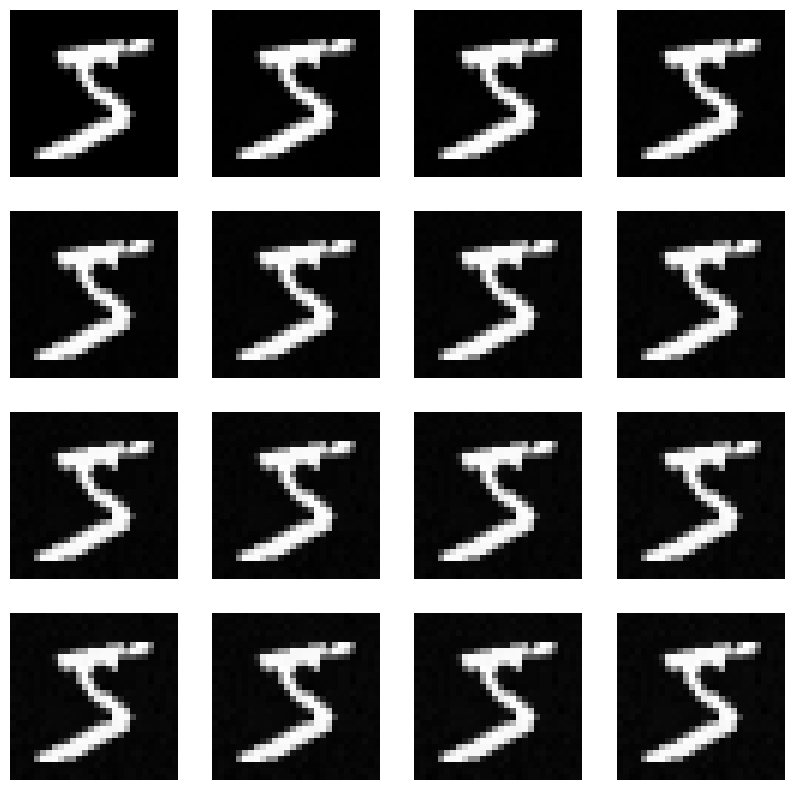

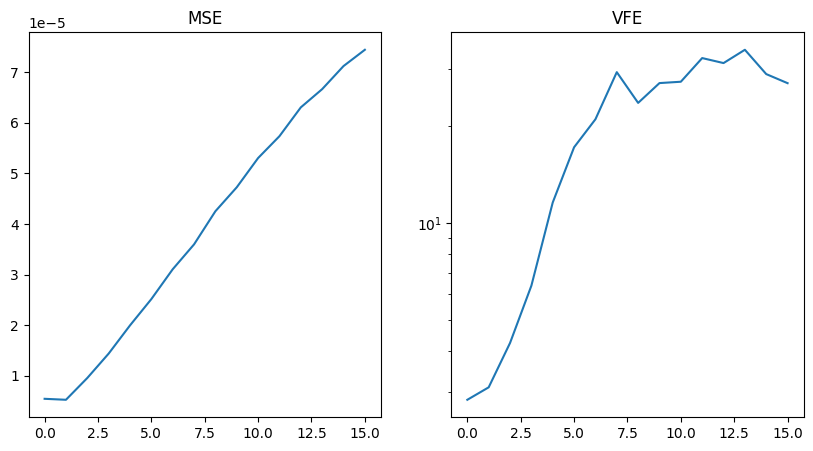

In [12]:
model.eval()
state = [{k: v.clone() for k, v in pos_state.items()} for pos_state in pos_state]
og = train_dataset.transformed_images.flatten(1).clone()
vfes = []
errs = []


# Plot the first 1st digit after multiple steps
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes):
    for j, ax2 in enumerate(ax):
        img = state[0]['x'][0].cpu().reshape(28,28).detach()
        # img = (x.cpu().reshape(28,28).detach() - og.cpu().reshape(28,28).detach()).abs()
        ax2.imshow(img, cmap='gray')
        model.step(state, torch.ones(10, device=device) * 1.0, pin_obs=False)
        # for _ in range(10):
        #     model.step(state, pin_obs=False)
        errs.append(F.mse_loss(state[0]['x'], og).item())
        vfes.append(model.vfe(state).item())
        ax2.axis('off')

plt.show()

# Plot MSE and VFE, VFE logarithmically
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(errs)
axes[0].set_title('MSE')
axes[1].plot(vfes)
axes[1].set_yscale('log')
axes[1].set_title('VFE')
plt.show()

In [ ]:
def train_classifier(
        model,
        classifier,
        NUM_EPOCHS,
        train_dataset,
        val_dataset,
        stats,
):
    # Init data
    trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=200, shuffle=True)
    valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=200, shuffle=False)

    for i in range(NUM_EPOCHS):

        # Epoch stats
        epochLosses = []

        optimiser = torch.optim.AdamW(classifier.parameters(), lr=0.001)  

        # TQDM loop
        loop = tqdm(trainLoader, total=len(trainLoader), leave=False)
        loop.set_description('Epoch [{}/{}]'.format(i, NUM_EPOCHS))
        if stats['epoch'] > 0:
            loop.set_postfix({'steps': i, 'valAcc': stats['valAcc'][-1], 'valLoss': stats['valLoss'][-1]})

        # Iterate over all batches
        for (images, labels) in loop:
            images = images.flatten(1)

            out, state = model(images)
            out = classifier(out)

            model.zero_grad()
            loss = F.cross_entropy(out, labels)
            loss.backward()
            optimiser.step()
            epochLosses.append(loss.item())

        # Track epoch stats
        stats['trainLoss'].append(torch.tensor(epochLosses).mean())

        # Update learning rate
        # if scheduler is not None:
        #     scheduler.step(stats['ValAcc'][-1])

        # Validation pass
        val_results = val_pass(model, None, valLoader, True, True, None)
        stats['valAcc'].append(val_results['acc'].item())
        stats['valLoss'].append(val_results['loss'].item())
        
        stats['epoch'] += 1

In [ ]:
classifier = torch.nn.Sequential(
    torch.nn.Linear(20, 10),
).to(device)
class_stats = {
    'epoch': 0,
    'trainLoss': [],
    'valAcc': [],
    'valLoss': [],
}

In [ ]:
train_classifier(
    model,
    classifier,
    NUM_EPOCHS,
    train_dataset,
    val_dataset,
    class_stats,
    # eval_every=10,
)